# Region Encoding Extraction

The RPN module of mlmodule allows users to extract regions from images using RPNs, and to create encodings for these regions using a DenseNet pretrained on ImageNet.

**Note:** There is a difference in output between `mlmodule` and `mmdetection` if the images are not loaded in the same way (such as if the URL of the image is passed to `inference_detector`). To get the same results, pass `np.array(pil_image)` as a parameter to `mmdetection` instead of the URL (don't forget to convert the image to RGB if it isn't RGB).

## Setup

### Imports

In [1]:
%cd ..

/home/poulsen/mlmodule


In [2]:
import pickle
import os
import time

import cv2 as cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.transforms import Compose

from mmdet.apis import init_detector, inference_detector

from mlmodule.contrib.rpn import RegionFeatures, RPN, CosineSimilarityRegionSelector, DenseNet161ImageNetEncoder
from mlmodule.torch.data.base import IndexedDataset
from mlmodule.torch.data.images import convert_to_rgb, get_pil_image_from_file
from mlmodule.utils import list_files_in_dir

### Loading Images

In [3]:
num_images = 10

img_file_names_path = '../imagenet_densenet201_softmax.pkl'

file_names = []
for i, k in enumerate(pickle.load(open(img_file_names_path, 'rb')).keys()):
    file_names.append(k)

file_names = [f for f in file_names if os.path.isfile(f)]
file_names = file_names[:num_images]

file_names[0]

'/mnt/storage01/massonnet/data-platform_media/sempi/1d186eb2-646d-11ea-a45e-02420a0000bd/c8b18052-8303-11e9-8101-02420a0006fd.jpg'

In [4]:
def get_images():
    transforms = Compose([
        get_pil_image_from_file,
        convert_to_rgb
    ])
    return file_names, [transforms(f) for f in file_names]

In [5]:
indices, images = get_images()

indices[0]

'/mnt/storage01/massonnet/data-platform_media/sempi/1d186eb2-646d-11ea-a45e-02420a0000bd/c8b18052-8303-11e9-8101-02420a0006fd.jpg'

### Region Extraction Parameters

In [6]:
MIN_SCORE = 0.5
NUM_REGIONS = 30

In [7]:
base_path = 'src/mlmodule/contrib/rpn'

model_configs = {
    'ga32': {'config': f'{base_path}/configs/guided_anchoring/ga_rpn_x101_32x4d_fpn_1x_coco.py',
             'checkpoint': f'{base_path}/checkpoints/ga_rpn_x101_32x4d_fpn_1x_coco_20200220-c28d1b18.pth',
             'min_conf': MIN_SCORE,
             'batch': False},
}

### Helpers

In [8]:
def add_boxes(image, boxes, c=(255, 0, 0)):
    img = image.copy()
    for bbox in boxes:
        x0, y0 = int(bbox[0]), int(bbox[1])
        x1, y1 = int(bbox[2]), int(bbox[3])
        cv2.rectangle(img, (x0, y0), (x1, y1), c, 2)
    return img


def plot_image_data(img_index):
    img_path, regions = regions_with_features[img_index]
    
    img = np.array(convert_to_rgb(get_pil_image_from_file(img_path)))
    
    # mmdetection boxes
    mmdet_all_boxes = mmdet_img_boxes[img_index]
    mmdet_all_scores = mmdet_img_scores[img_index]
    mmdet_boxes = mmdet_all_boxes[mmdet_all_scores.squeeze() > MIN_SCORE]
    
    
    # mlmodule boxes
    boxes_taken = []
    boxes_not_taken = []
    for r in regions:
        b0, b1 = r.bounding_box
        if r.features is not None:
            boxes_taken.append([b0.x, b0.y, b1.x, b1.y])
        else:
            boxes_not_taken.append([b0.x, b0.y, b1.x, b1.y])
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 10))
    ax1.set_title(f'mmdet ({len(mmdet_boxes)})')
    ax1.imshow(add_boxes(img, mmdet_boxes, c=(255, 0, 0)))
    ax2.set_title(f'mlmodule: Regions Kept ({len(boxes_taken)})')
    ax2.imshow(add_boxes(img, boxes_taken, c=(255, 0, 0)))
    ax3.set_title(f'mlmodule: Regions Discarded ({len(boxes_not_taken)})')
    ax3.imshow(add_boxes(img, boxes_not_taken, c=(255, 0, 0)))
    plt.tight_layout()
    plt.show()

## Region Extraction: Using mmdetection

In [9]:
def extract_regions(model, file_names, num_regions):
    m = init_detector(model['config'], model['checkpoint'], device='cuda:0')
    boxes = []
    scores = []
    for f in file_names:
        results = inference_detector(m, f)
        
        # Extract boxes and scores from results
        img_boxes = results[:num_regions, :4]
        img_scores = results[:num_regions, 4:]
        
        # Confidence thresholding
        img_boxes = img_boxes[img_scores.squeeze() > model['min_conf']]
        img_scores = img_scores[img_scores.squeeze() > model['min_conf']]
        
        # Append to list
        boxes.append(img_boxes)
        scores.append(img_scores)
        
    # Clear model from cuda
    del m
    torch.cuda.empty_cache()
    return boxes, scores

In [10]:
boxes, scores = extract_regions(model_configs['ga32'], file_names, NUM_REGIONS)
mmdet_img_boxes = boxes
mmdet_img_scores = scores

Use load_from_local loader


/home/poulsen/.conda/envs/mlmodule/lib/python3.7/site-packages/mmdet/datasets/utils.py:68: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)
/home/poulsen/.conda/envs/mlmodule/lib/python3.7/site-packages/mmcv/ops/masked_conv.py:65: UserWarning: This overload of addmm is deprecated:
	addmm(Number beta, Tensor input, Number alpha, Tensor mat1, Tensor mat2, *, Tensor out)
Consider using one of the following signatures instead:
	addmm(Tensor input, Tensor mat1, Tensor mat2, *, Number beta, Number alpha, Tensor out) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:882.)
  weight.view(out_channel, -1), data_col)


## Region Extraction: Using mlmodule

### Creating the Dataset

In [11]:
dataset = IndexedDataset[str, np.ndarray, np.ndarray](indices, images)

### Loading the Models

In [12]:
def rpn():
    base_path = 'src/mlmodule/contrib/rpn'
    config = f'{base_path}/configs/guided_anchoring/ga_rpn_x101_32x4d_fpn_1x_coco.py'
    checkpoint = f'{base_path}/checkpoints/ga_rpn_x101_32x4d_fpn_1x_coco_20200220-c28d1b18.pth'

    # Initialize RPN
    model = RPN(config, device='cuda:0')
    # Load checkpoint
    with open(checkpoint, 'rb') as f:
        model.load(f)
    return model


def region_encoder():
    densenet = DenseNet161ImageNetEncoder(device='cuda:0')
    densenet.load()
    return densenet


def region_selector():
    return CosineSimilarityRegionSelector(device='cuda:0')

In [13]:
rpn = rpn()
region_encoder = region_encoder()
region_selector = region_selector()

In [14]:
region_features = RegionFeatures(rpn, region_encoder, region_selector)

### Computing Image Regions and Their Encodings

In [15]:
t0 = time.time()
regions_with_features = region_features.bulk_inference(
    dataset,
    regions_per_image=NUM_REGIONS,
    min_region_score=MIN_SCORE
)
t1 = time.time()

print(f'Images in dataset: {len(dataset)}')
print(f'Runtime:           {t1 - t0:.1f} seconds')
print(f'Per image:         {len(dataset)/(t1 - t0):.1f} images/second')

Images in dataset: 10
Runtime:           17.3 seconds
Per image:         0.6 images/second


## Analysing Results

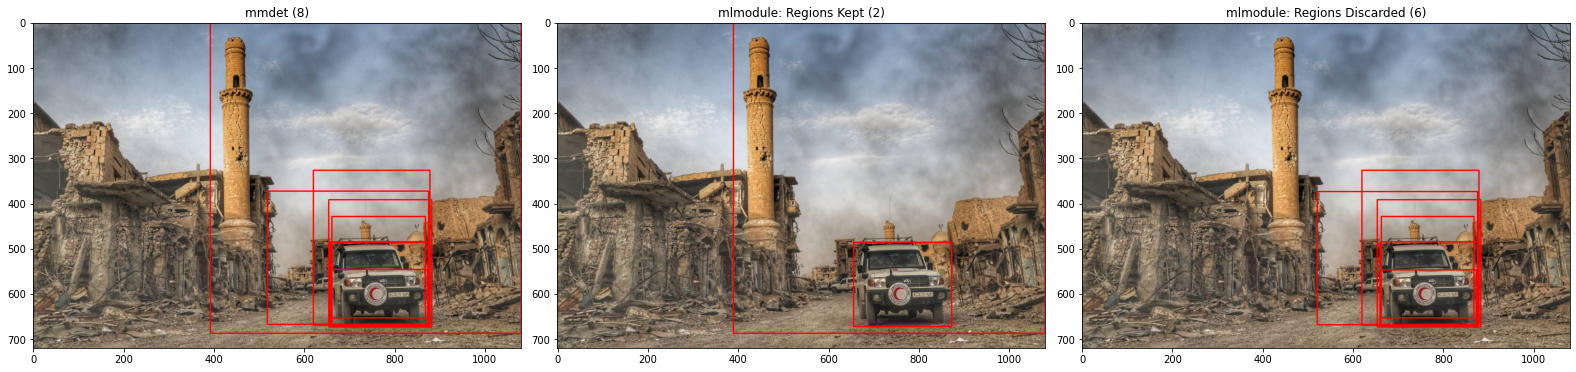

In [16]:
plot_image_data(0)

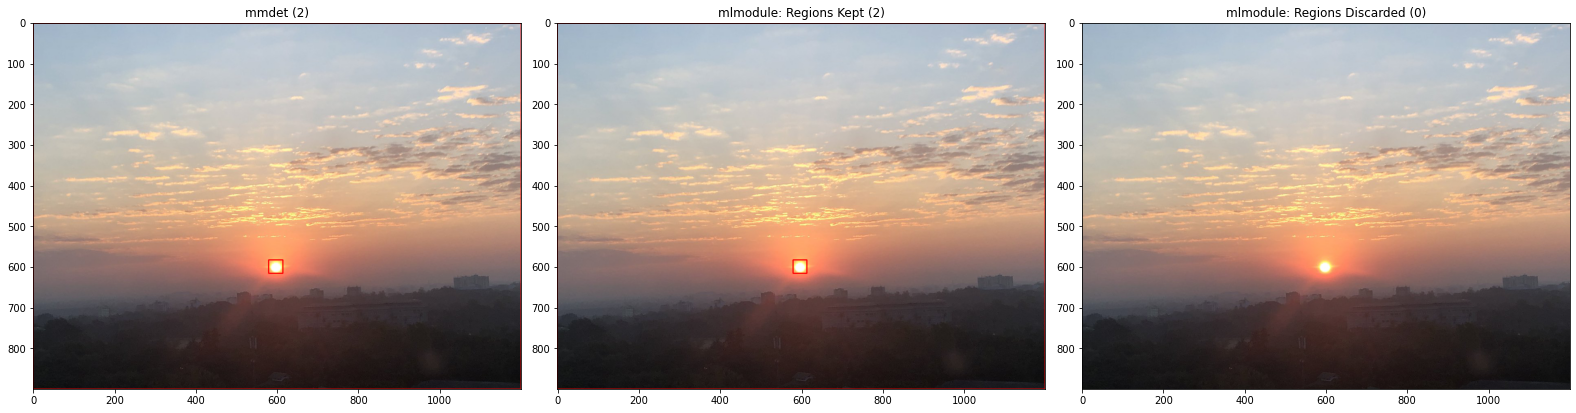

In [17]:
plot_image_data(1)

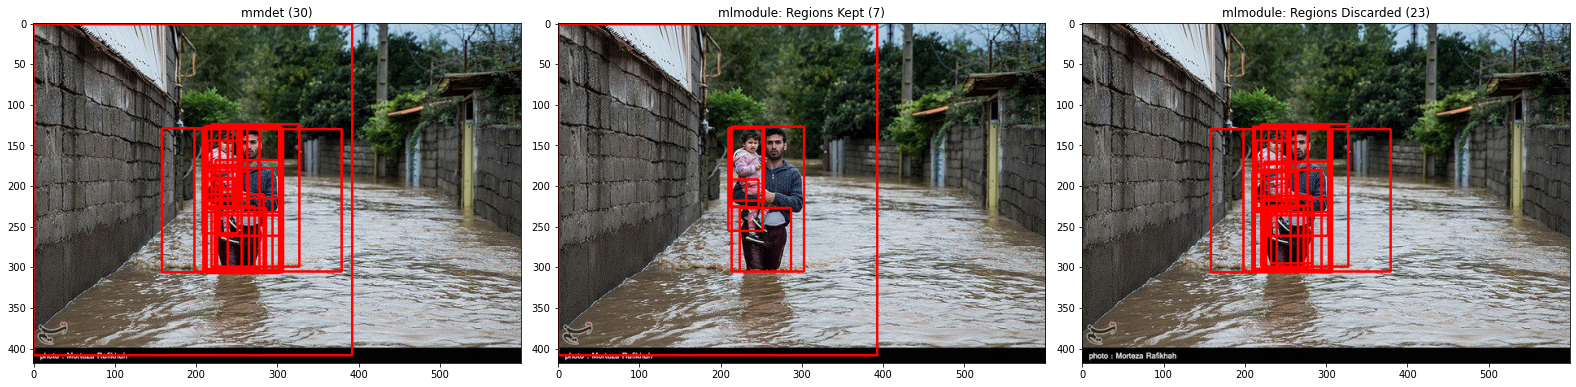

In [18]:
plot_image_data(2)

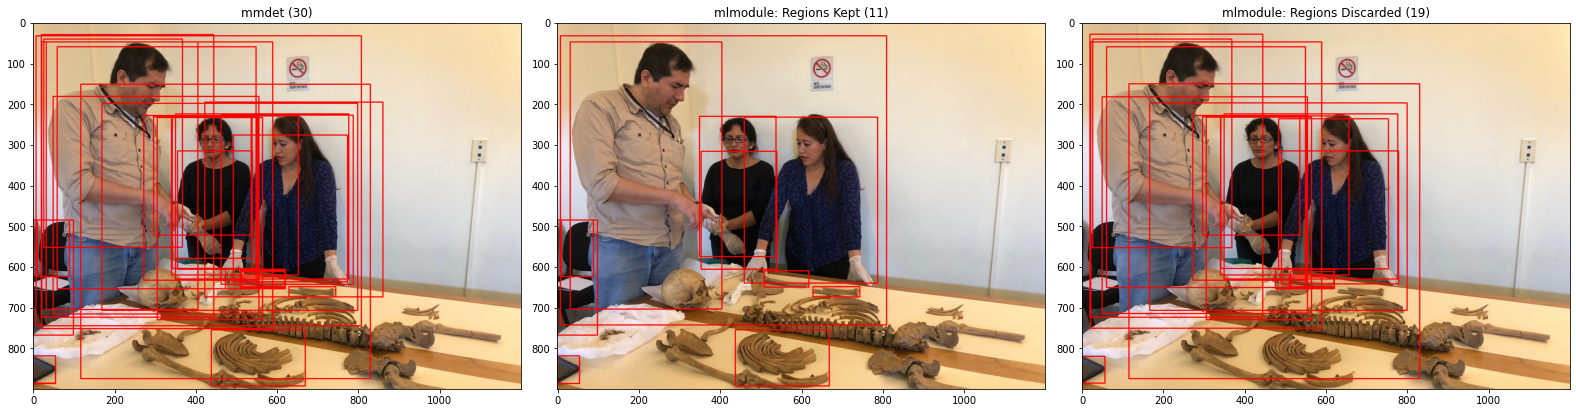

In [19]:
plot_image_data(3)

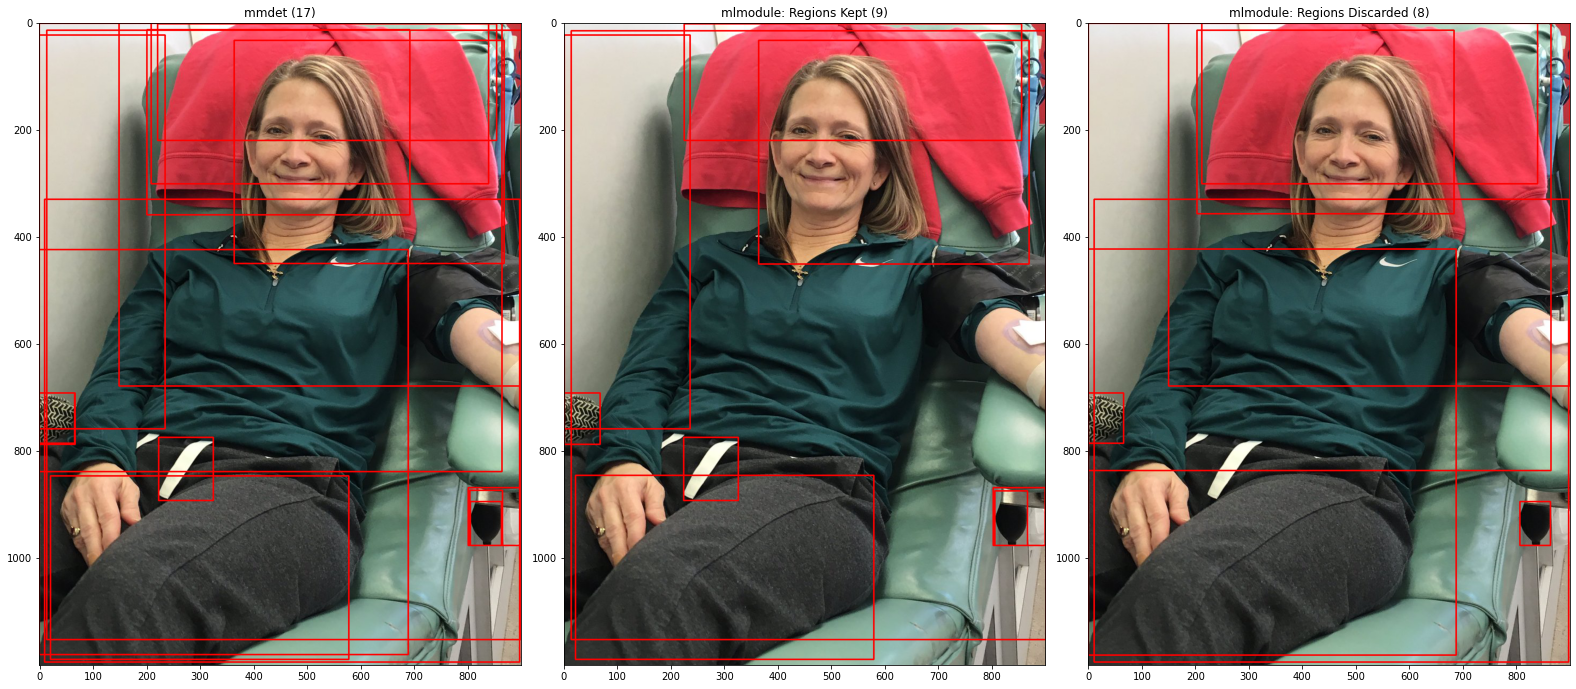

In [20]:
plot_image_data(4)